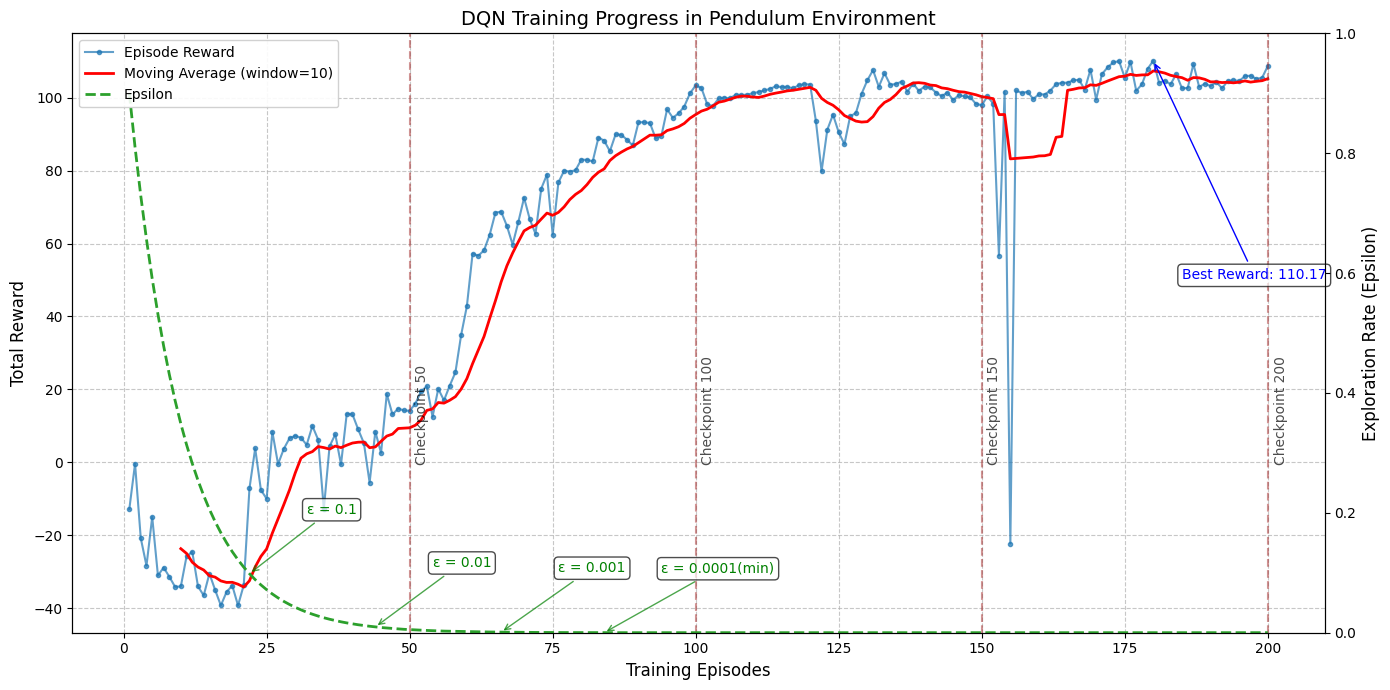

In [1]:
# visualization of DQN training progress in the Pendulum environment


import re
import matplotlib.pyplot as plt


import numpy as np


# Read the log file


with open(r"..\logs\pendulum\dqn.log", "r") as f:
    log_content = f.read()


# Extract episode rewards using regex


reward_pattern = r"Episode (\d+)/\d+: Total Reward: ([-\d\.]+)"
reward_matches = re.findall(reward_pattern, log_content)


# Extract epsilon values


epsilon_pattern = r"Episode \d+/\d+:.*Epsilon: ([\d\.]+)"
epsilon_matches = re.findall(epsilon_pattern, log_content)


# Parse the data
episodes = [int(match[0]) for match in reward_matches]
rewards = [float(match[1]) for match in reward_matches]
epsilons = [float(eps) for eps in epsilon_matches]


# Create the figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))


# Plot rewards on the left y-axis


color = "tab:blue"
ax1.set_xlabel("Training Episodes", fontsize=12)
ax1.set_ylabel("Total Reward", fontsize=12)
ax1.plot(episodes, rewards, "o-", color=color, markersize=3, alpha=0.7, label="Episode Reward")


# Add smoothed line (moving average)
window_size = 10
smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
ax1.plot(
    episodes[window_size - 1 :], smoothed_rewards, "r-", linewidth=2, label=f"Moving Average (window={window_size})"
)


ax1.tick_params(axis="y")


# Create a second y-axis for epsilon
ax2 = ax1.twinx()


color = "tab:green"
ax2.set_ylabel("Exploration Rate (Epsilon)", fontsize=12)


ax2.plot(episodes, epsilons, "--", color=color, linewidth=2, label="Epsilon")
ax2.tick_params(axis="y")
ax2.set_ylim(0, 1.0)  # Set reasonable limits for epsilon


# Add a title


plt.title("DQN Training Progress in Pendulum Environment", fontsize=14)


# Add grid


ax1.grid(True, linestyle="--", alpha=0.7)


# Mark checkpoint episodes


checkpoints = [50, 100, 150, 200]
for checkpoint in checkpoints:
    ax1.axvline(x=checkpoint, color="brown", linestyle="--", alpha=0.5)
    ax1.text(checkpoint + 1, 0, f"Checkpoint {checkpoint}", rotation=90, alpha=0.7)


# Annotate key points


best_reward_idx = np.argmax(rewards)
ax1.annotate(
    f"Best Reward: {rewards[best_reward_idx]:.2f}",
    xy=(episodes[best_reward_idx], rewards[best_reward_idx]),
    xytext=(episodes[best_reward_idx] + 5, rewards[best_reward_idx] - 60),
    arrowprops=dict(arrowstyle="->", color="blue"),
    color="blue",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
)


# Annotate specific epsilon values (0.1, 0.01, 0.001, 0.0001)
epsilon_targets = [0.1, 0.01, 0.001, 0.0001]
for eps_value in epsilon_targets:
    # Find the closest epsilon value and its index

    eps_idx = min(range(len(epsilons)), key=lambda i: abs(epsilons[i] - eps_value))

    # Add annotation if the epsilon value is close enough
    if abs(epsilons[eps_idx] - eps_value) < 0.05:  # Tolerance threshold
        ax2.annotate(
            f"ε = {eps_value}" + ("(min)" if eps_value == 0.0001 else ""),
            xy=(episodes[eps_idx], epsilons[eps_idx]),
            xytext=(episodes[eps_idx] + 10, epsilons[eps_idx] + 0.1),
            arrowprops=dict(arrowstyle="->", color="green", alpha=0.7),
            color="green",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
        )


# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=True, framealpha=0.9)


plt.tight_layout()
plt.show()

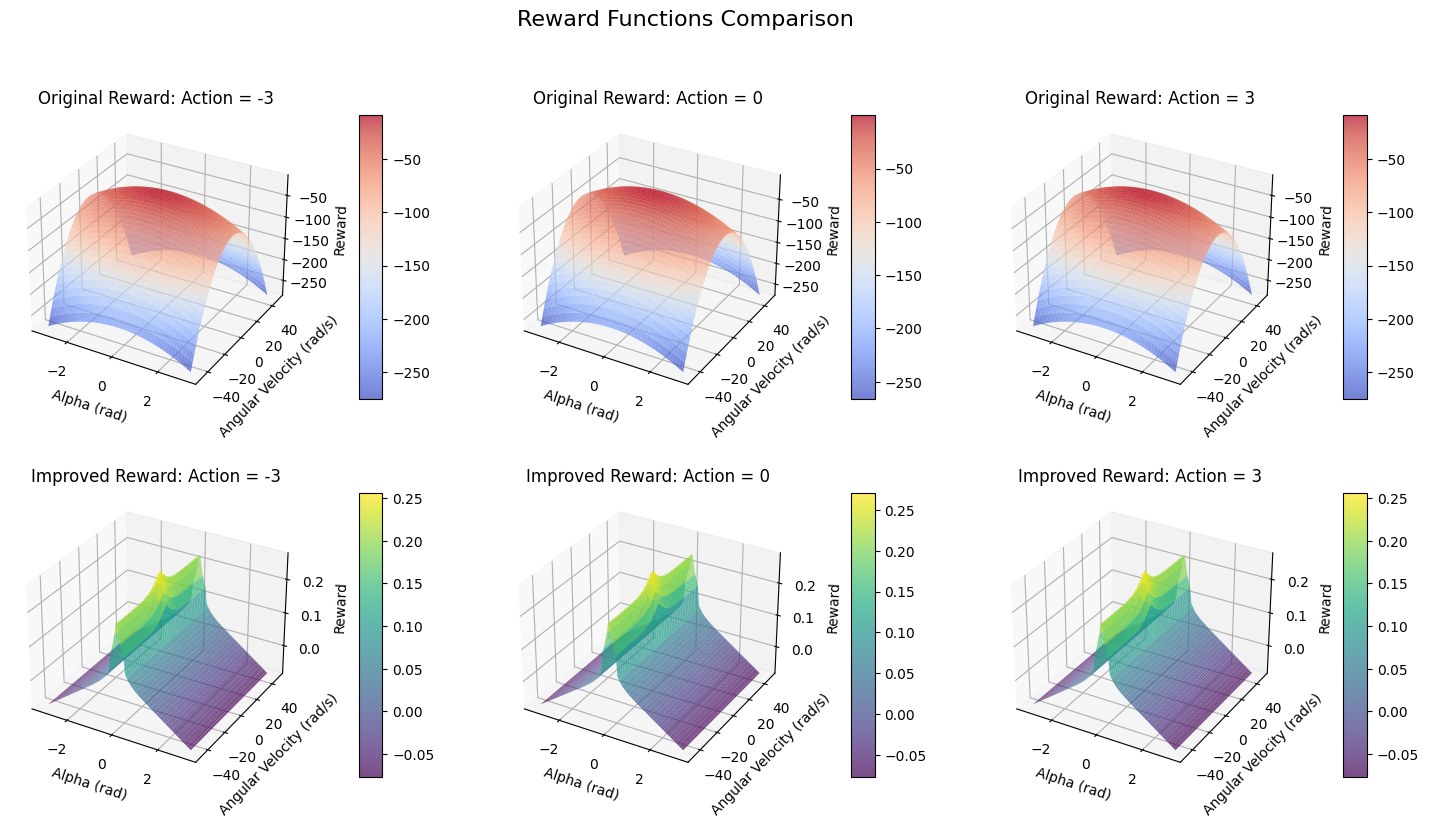

In [2]:
# original reward
# reward = -5 * np.power(self.alpha, 2) - 0.1 * np.power(self.dot_alpha, 2) - np.power(action, 2)

# improved reward
# upright_angle = -np.abs(self.alpha) + np.pi / 2
# reward = 0.05 * (
#     upright_angle + 0.001 * np.exp(upright_angle * 5)
# )  # higher value like 0.2 or lower value like 0.001 might be hard for DQN to learn

# if np.abs(np.degrees(self.alpha)) < 20:
#     velocity_penalty = 0.05 * (np.tanh(np.abs(self.dot_alpha) * 0.1))
#     action_penalty = 0.05 * (np.tanh(np.abs(action) * 0.1))
#     reward += 0.1 - velocity_penalty - action_penalty  # Extra reward approaches 0 as velocity increases

# action: [-3, 0, 3], alpha: [-pi, pi], dot_alpha: [-15pi, 15pi]  # Updated action range
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Define the domain ranges
alpha_range = np.linspace(-np.pi, np.pi, 100)
dot_alpha_range = np.linspace(-15 * np.pi, 15 * np.pi, 100)
actions = [-3, 0, 3]

# Create meshgrid for 3D plotting
alpha_mesh, dot_alpha_mesh = np.meshgrid(alpha_range, dot_alpha_range)


# Define original reward function
def original_reward(alpha, dot_alpha, action):
    return -5 * np.power(alpha, 2) - 0.1 * np.power(dot_alpha, 2) - np.power(action, 2)


# Define improved reward function
def improved_reward(alpha, dot_alpha, action):
    upright_angle = -np.abs(alpha) + np.pi / 2
    reward = 0.05 * (upright_angle + 0.001 * np.exp(upright_angle * 5))

    # Add extra reward for angles within 20 degrees of vertical
    angle_deg = np.abs(np.degrees(alpha))
    mask = angle_deg < 20

    velocity_penalty = 0.05 * (np.tanh(np.abs(dot_alpha) * 0.1))
    action_penalty = 0.05 * (np.tanh(np.abs(action) * 0.1))

    extra_reward = np.zeros_like(alpha)
    extra_reward[mask] = 0.1 - velocity_penalty[mask] - action_penalty

    return reward + extra_reward


# Create a single figure with two rows for both reward functions
fig = plt.figure(figsize=(18, 9))

# Add subplot for original reward in top row
fig.suptitle("Reward Functions Comparison", fontsize=16)

# Plot original reward for each action in top row
for i, action in enumerate(actions):
    # Calculate reward values for current action
    reward_values = np.zeros_like(alpha_mesh)
    for j in range(len(alpha_range)):
        for k in range(len(dot_alpha_range)):
            reward_values[k, j] = original_reward(alpha_mesh[k, j], dot_alpha_mesh[k, j], action)

    # Add subplot to top row (original reward)
    ax = fig.add_subplot(2, 3, i + 1, projection="3d")
    surf = ax.plot_surface(
        alpha_mesh, dot_alpha_mesh, reward_values, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=0.7
    )

    # Set labels and title
    ax.set_xlabel("Alpha (rad)")
    ax.set_ylabel("Angular Velocity (rad/s)")
    ax.set_zlabel("Reward")
    ax.set_title(f"Original Reward: Action = {action}")

    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.9, aspect=12, pad=0.14)

# Plot improved reward for each action in bottom row
for i, action in enumerate(actions):
    # Calculate reward values for current action
    reward_values = np.zeros_like(alpha_mesh)
    for j in range(len(alpha_range)):
        for k in range(len(dot_alpha_range)):
            reward_values[k, j] = improved_reward(alpha_mesh[k, j], dot_alpha_mesh[k, j], action)

    # Add subplot to bottom row (improved reward)
    ax = fig.add_subplot(2, 3, i + 4, projection="3d")
    surf = ax.plot_surface(
        alpha_mesh, dot_alpha_mesh, reward_values, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7
    )

    # Set labels and title
    ax.set_xlabel("Alpha (rad)")
    ax.set_ylabel("Angular Velocity (rad/s)")
    ax.set_zlabel("Reward")
    ax.set_title(f"Improved Reward: Action = {action}")

    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.9, aspect=12, pad=0.14)

# Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

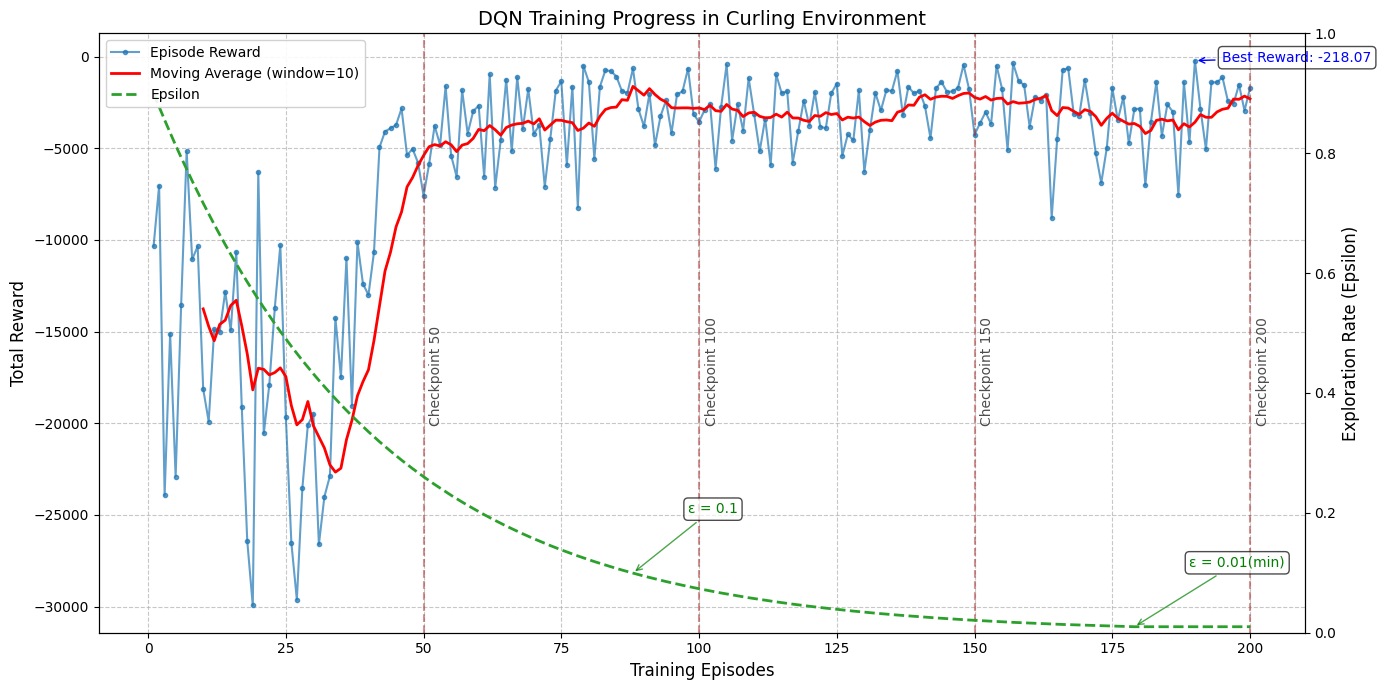

In [3]:
# visualization of DQN training progress in the Curling environment


import re
import matplotlib.pyplot as plt
import numpy as np


# Read the log file
with open(r"..\logs\curling\dqn.log", "r") as f:
    log_content = f.read()


# Extract episode rewards using regex
reward_pattern = r"Episode (\d+)/\d+: Total Reward: ([-\d\.]+)"
reward_matches = re.findall(reward_pattern, log_content)


# Extract epsilon values
epsilon_pattern = r"Episode \d+/\d+:.*Epsilon: ([\d\.]+)"
epsilon_matches = re.findall(epsilon_pattern, log_content)


# Parse the data
episodes = [int(match[0]) for match in reward_matches]
rewards = [float(match[1]) for match in reward_matches]
epsilons = [float(eps) for eps in epsilon_matches]


# Create the figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))


# Plot rewards on the left y-axis
color = "tab:blue"
ax1.set_xlabel("Training Episodes", fontsize=12)
ax1.set_ylabel("Total Reward", fontsize=12)
ax1.plot(episodes, rewards, "o-", color=color, markersize=3, alpha=0.7, label="Episode Reward")


# Add smoothed line (moving average)
window_size = 10
smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
ax1.plot(
    episodes[window_size - 1 :], smoothed_rewards, "r-", linewidth=2, label=f"Moving Average (window={window_size})"
)


ax1.tick_params(axis="y")
# Create a second y-axis for epsilon
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Exploration Rate (Epsilon)", fontsize=12)
ax2.plot(episodes, epsilons, "--", color=color, linewidth=2, label="Epsilon")
ax2.tick_params(axis="y")
ax2.set_ylim(0, 1.0)  # Set reasonable limits for epsilon


# Add a title
plt.title("DQN Training Progress in Curling Environment", fontsize=14)


# Add grid
ax1.grid(True, linestyle="--", alpha=0.7)


# Mark checkpoint episodes
checkpoints = [50, 100, 150, 200]
for checkpoint in checkpoints:
    ax1.axvline(x=checkpoint, color="brown", linestyle="--", alpha=0.5)
    ax1.text(checkpoint + 1, -20000, f"Checkpoint {checkpoint}", rotation=90, alpha=0.7)


# Annotate key points


best_reward_idx = np.argmax(rewards)
ax1.annotate(
    f"Best Reward: {rewards[best_reward_idx]:.2f}",
    xy=(episodes[best_reward_idx], rewards[best_reward_idx]),
    xytext=(episodes[best_reward_idx] + 5, rewards[best_reward_idx] - 60),
    arrowprops=dict(arrowstyle="->", color="blue"),
    color="blue",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
)


# Annotate specific epsilon values (0.1, 0.01, 0.001, 0.0001)
epsilon_targets = [0.1, 0.01]
for eps_value in epsilon_targets:
    # Find the closest epsilon value and its index

    eps_idx = min(range(len(epsilons)), key=lambda i: abs(epsilons[i] - eps_value))

    # Add annotation if the epsilon value is close enough
    if abs(epsilons[eps_idx] - eps_value) < 0.05:  # Tolerance threshold
        ax2.annotate(
            f"ε = {eps_value}" + ("(min)" if eps_value == 0.01 else ""),
            xy=(episodes[eps_idx], epsilons[eps_idx]),
            xytext=(episodes[eps_idx] + 10, epsilons[eps_idx] + 0.1),
            arrowprops=dict(arrowstyle="->", color="green", alpha=0.7),
            color="green",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
        )


# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=True, framealpha=0.9)


plt.tight_layout()
plt.show()

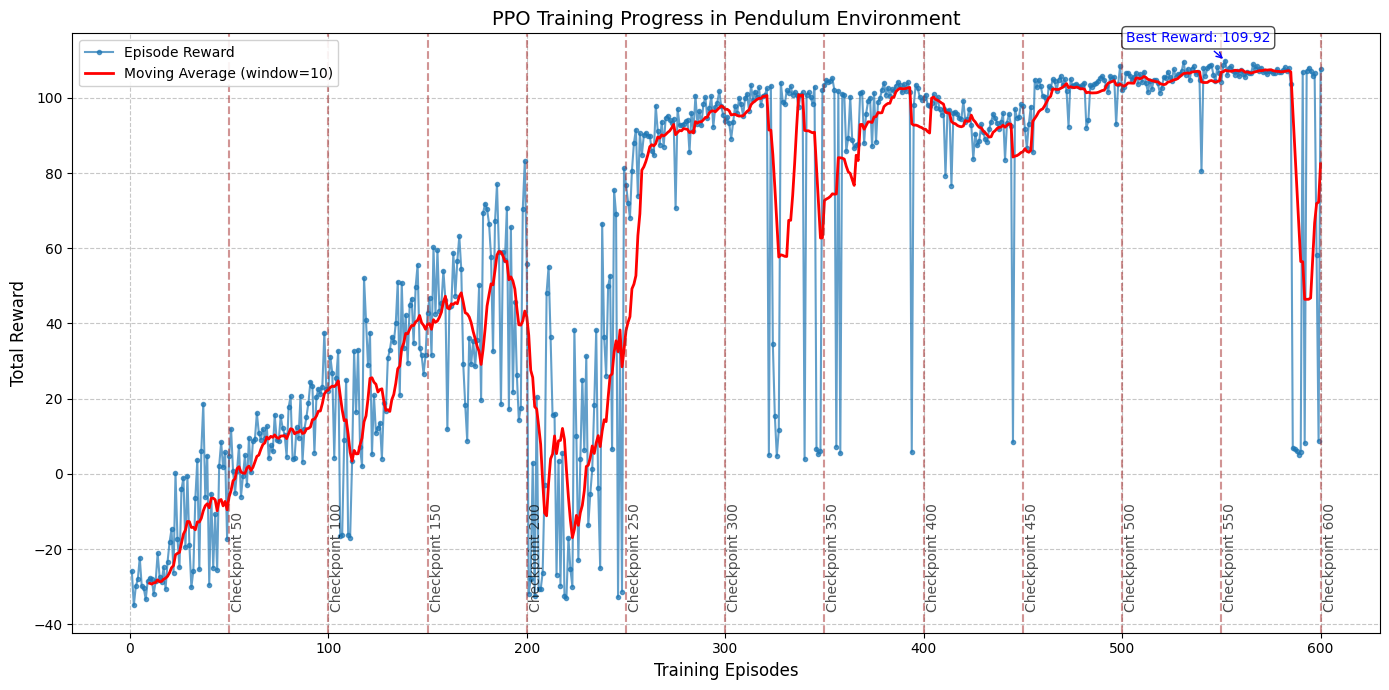

In [ ]:
# visualization of PPO training progress in the Pendulum environment

import re
import matplotlib.pyplot as plt
import numpy as np

# Read the log file
with open(r"..\logs\pendulum\ppo.log", "r") as f:
    log_content = f.read()

# Extract episode rewards using regex
reward_pattern = r"Episode (\d+)/\d+: Total Reward: ([-\d\.]+)"
reward_matches = re.findall(reward_pattern, log_content)

# Extract batch update information (for additional analysis)
# update_pattern = r"Update after (\d+) steps \((\d+) episodes\): Avg Episode Reward: ([-\d\.]+), Loss: ([-\d\.]+)"
# update_matches = re.findall(update_pattern, log_content)

# Parse the data
episodes = [int(match[0]) for match in reward_matches]
rewards = [float(match[1]) for match in reward_matches]

# update_steps = [int(match[0]) for match in update_matches]
# update_episodes = [int(match[1]) for match in update_matches]
# update_rewards = [float(match[2]) for match in update_matches]
# update_losses = [float(match[3]) for match in update_matches]

# Create the figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot rewards
color = "tab:blue"
ax1.set_xlabel("Training Episodes", fontsize=12)
ax1.set_ylabel("Total Reward", fontsize=12)
ax1.plot(episodes, rewards, "o-", color=color, markersize=3, alpha=0.7, label="Episode Reward")

# Add smoothed line (moving average)
window_size = 10
if len(rewards) > window_size:
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
    ax1.plot(
        episodes[window_size - 1 :], smoothed_rewards, "r-", linewidth=2, label=f"Moving Average (window={window_size})"
    )
ax1.tick_params(axis="y")

# Add a title
plt.title("PPO Training Progress in Pendulum Environment", fontsize=14)

# Add grid
ax1.grid(True, linestyle="--", alpha=0.7)

# Mark checkpoint episodes
checkpoints = range(50, 601, 50)  # Example checkpoints
for checkpoint in checkpoints:
    if checkpoint <= max(episodes):
        ax1.axvline(x=checkpoint, color="brown", linestyle="--", alpha=0.5)
        ax1.text(checkpoint + 1, min(rewards) - 1, f"Checkpoint {checkpoint}", rotation=90, alpha=0.7)

# Annotate key points
best_reward_idx = np.argmax(rewards)
ax1.annotate(
    f"Best Reward: {rewards[best_reward_idx]:.2f}",
    xy=(episodes[best_reward_idx], rewards[best_reward_idx]),
    xytext=(episodes[best_reward_idx] - 50, rewards[best_reward_idx] + 5),
    arrowprops=dict(arrowstyle="->", color="blue"),
    color="blue",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
)


# Add legend
ax1.legend(loc="upper left", frameon=True, framealpha=0.9)


plt.tight_layout()
plt.show()

# Optional: Create a second plot for loss values
# fig2, ax2 = plt.subplots(figsize=(14, 5))
# ax2.plot(range(len(update_losses)), update_losses, "o-", color="purple", markersize=3, alpha=0.7)
# ax2.set_xlabel("Update Steps", fontsize=12)
# ax2.set_ylabel("Loss", fontsize=12)
# ax2.set_title("PPO Loss During Training", fontsize=14)
# ax2.grid(True, linestyle="--", alpha=0.7)
# plt.tight_layout()
# plt.show()

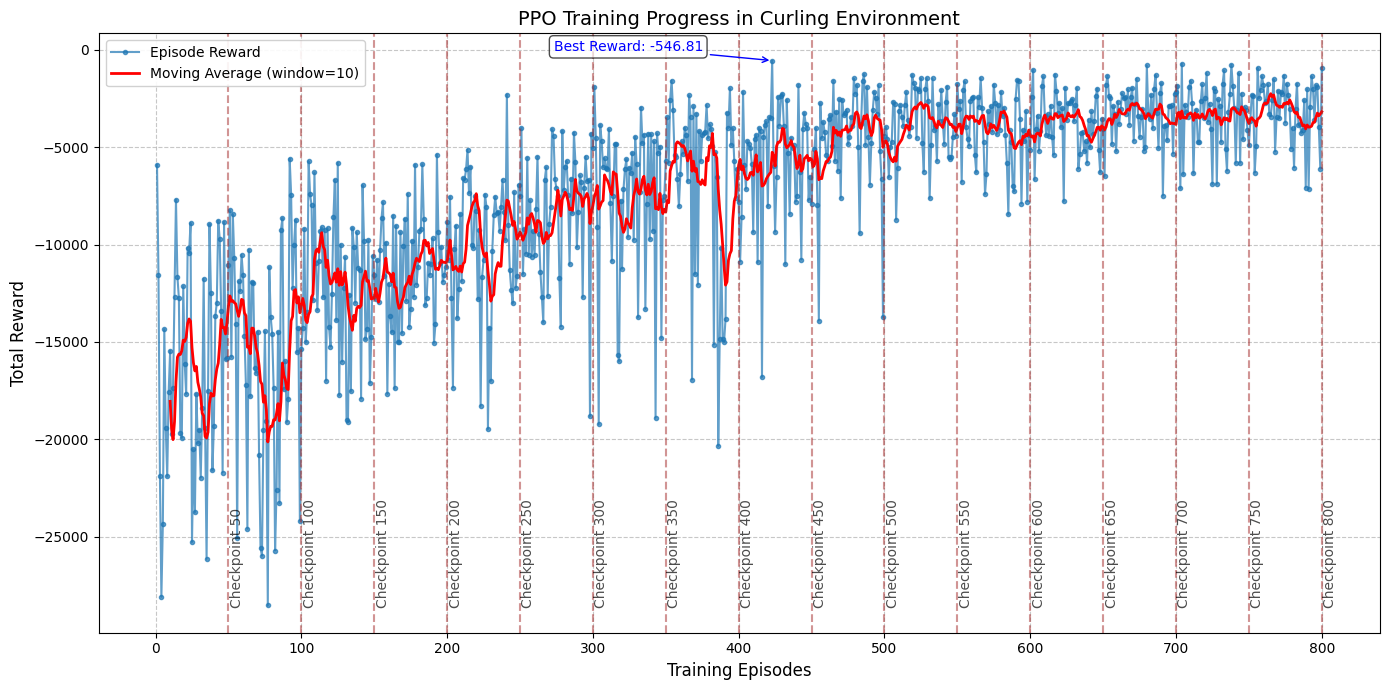

In [38]:
# visualization of PPO training progress in the Curling environment

import re
import matplotlib.pyplot as plt
import numpy as np

# Read the log file
with open(r"..\logs\curling\ppo.log", "r") as f:
    log_content = f.read()

# Extract episode rewards using regex
reward_pattern = r"Episode (\d+)/\d+: Total Reward: ([-\d\.]+)"
reward_matches = re.findall(reward_pattern, log_content)

# Extract batch update information (for additional analysis)
# update_pattern = r"Update after (\d+) steps \((\d+) episodes\): Avg Episode Reward: ([-\d\.]+), Loss: ([-\d\.]+)"
# update_matches = re.findall(update_pattern, log_content)

# Parse the data
episodes = [int(match[0]) for match in reward_matches]
rewards = [float(match[1]) for match in reward_matches]
# unscale the reward
rewards = [np.linalg.norm(np.array([100, 100])) * reward for reward in rewards]

# update_steps = [int(match[0]) for match in update_matches]
# update_episodes = [int(match[1]) for match in update_matches]
# update_rewards = [float(match[2]) for match in update_matches]
# update_losses = [float(match[3]) for match in update_matches]

# Create the figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot rewards
color = "tab:blue"
ax1.set_xlabel("Training Episodes", fontsize=12)
ax1.set_ylabel("Total Reward", fontsize=12)
ax1.plot(episodes, rewards, "o-", color=color, markersize=3, alpha=0.7, label="Episode Reward")

# Add smoothed line (moving average)
window_size = 10
if len(rewards) > window_size:
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
    ax1.plot(
        episodes[window_size - 1 :], smoothed_rewards, "r-", linewidth=2, label=f"Moving Average (window={window_size})"
    )
ax1.tick_params(axis="y")

# Add a title
plt.title("PPO Training Progress in Curling Environment", fontsize=14)

# Add grid
ax1.grid(True, linestyle="--", alpha=0.7)

# Mark checkpoint episodes
checkpoints = range(50, 801, 50)  # Example checkpoints
for checkpoint in checkpoints:
    if checkpoint <= max(episodes):
        ax1.axvline(x=checkpoint, color="brown", linestyle="--", alpha=0.5)
        ax1.text(checkpoint + 1, min(rewards) - 1, f"Checkpoint {checkpoint}", rotation=90, alpha=0.7)

# Annotate key points
best_reward_idx = np.argmax(rewards)
ax1.annotate(
    f"Best Reward: {rewards[best_reward_idx]:.2f}",
    xy=(episodes[best_reward_idx], rewards[best_reward_idx]),
    xytext=(episodes[best_reward_idx] - 150, rewards[best_reward_idx] + 500),
    arrowprops=dict(arrowstyle="->", color="blue"),
    color="blue",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
)


# Add legend
ax1.legend(loc="upper left", frameon=True, framealpha=0.9)


plt.tight_layout()
plt.show()

# Optional: Create a second plot for loss values
# fig2, ax2 = plt.subplots(figsize=(14, 5))
# ax2.plot(range(len(update_losses)), update_losses, "o-", color="purple", markersize=3, alpha=0.7)
# ax2.set_xlabel("Update Steps", fontsize=12)
# ax2.set_ylabel("Loss", fontsize=12)
# ax2.set_title("PPO Loss During Training", fontsize=14)
# ax2.grid(True, linestyle="--", alpha=0.7)
# plt.tight_layout()
# plt.show()